In [29]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint

In [136]:
def RosenzweigMacArthur(x, t, h2):
    c1 = 5.0
    h1 = 3.0
    c2 = 0.1
    m2 = 0.4
    m3 = 0.008
    
    dx = x[0]*(1-x[0]) - c1 * x[0] * x[1] / (1.0 + h1*x[0])
    dy = c1 * x[0] * x[1] / (1.0 + h1 * x[0]) - c2 * x[1] * x[2] / (1.0 + h2(t) * x[1]) - m2*x[1]
    dz = c2 * x[1] * x[2] / (1.0 + h2(t) * x[1]) - m3 * x[2]

    return (dx, dy, dz)

def Lorenz96P(x, t, F):
    N = 5 # dimension

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F(t)
    return d

In [31]:
def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

def delayEmbed(Xin, Yin,assignment,embInterval):
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            lag = 1
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    return (Xin, Yin)

In [199]:
settlingTime = 5

end = 2**10
tlen = 2 ** 18 + settlingTime
reduction = 2 ** 6
trainToTest = 0.90 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1
# t0 = np.array([0.5])
# t0 = np.ones(dim) * 0.3333# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# t0 = np.array([0.8,0.1,9])
t0 = np.ones(5)
t0[0] += 0.1

In [200]:
# Density Dependent Maturation
"""
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2)
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T

Xr = standardize(states[settlingTime:,0,None])
print(Xr.shape)
"""
"""
# Rosenzweig MacArthur
h2 = lambda t : 2.0 - 1.0 * t / end

Xr = standardize(odeint(RosenzweigMacArthur, t0, t, args=(h2,)))[::2**5,0,None]
"""

# Lorenz 96
F = lambda t : 7 + 7 * t / end

Xr = standardize(odeint(Lorenz96P, t0, t, args=(F,)))[::reduction,0,None]

In [201]:
""" UPDATE DRIVERS HERE """

digiDrivers = [F]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
gtsr = F(t) # driverArray

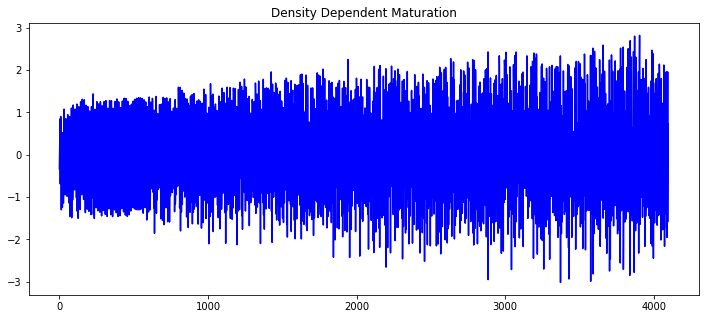

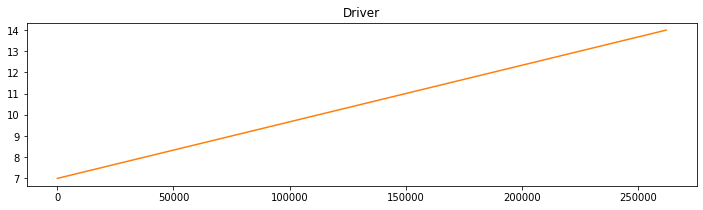

In [203]:
fig2 = plt.figure(2,figsize=(12,5))

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
ax2.set_title("Density Dependent Maturation")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

In [204]:
predictionStep = 1
X, Y = delayEmbed(Xr[:-predictionStep],Xr[predictionStep:],[6],1)

testTrainSplit = int(Xr.shape[0] * trainToTest)
Xtrain = X[:testTrainSplit]
Ytrain = Y[:testTrainSplit]
Xtest = X[testTrainSplit:]
Ytest = Y[testTrainSplit:]

[-0.17118039]


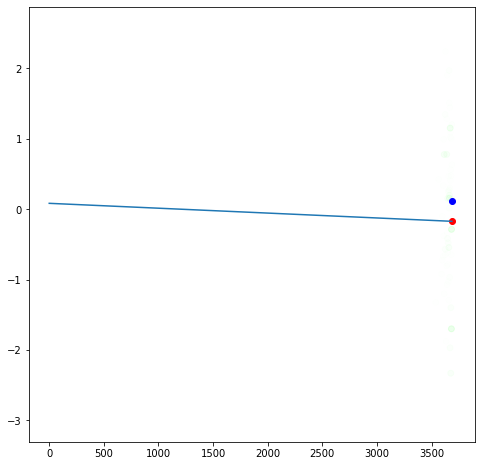

In [205]:
i = 1
pred = Xtest[i]
predTime = Xtrain.shape[0] + i

theta = 2 ** 2

# print(predTime - np.arange(0,Xtrain.shape[0]))
delta = 2 ** -5

norms = la.norm(pred - Xtrain,axis=1)
d = np.mean(norms)
weights = np.exp(-1*theta*la.norm(pred - Xtrain,axis=1)/d - delta * (predTime - np.arange(0,Xtrain.shape[0])))
weights = np.reshape(weights,(weights.shape[0],1))

np.set_printoptions(suppress=True)

A = np.hstack((np.arange(Ytrain.shape[0]).reshape((Ytrain.shape[0],1)), np.multiply(Ytrain,weights)))
tmean = np.dot(A[:,0],weights)/np.sum(weights)
amean = np.sum(A[:,1])/np.sum(weights)

slope = np.dot(A[:,1] - amean, A[:,0] - tmean) / np.dot(A[:,0] - tmean, A[:,0] - tmean)
intercept = amean - slope * tmean

lineOfBestFit = lambda t : intercept + slope * t

prediction = lineOfBestFit(predTime)

print(prediction)

# kernel = np.fromfunction(lambda i,j: np.exp(-1*la.norm(X[i]-X[j],axis=2)) , (X.shape[0],X.shape[0]),dtype=int)

figKernel, axKernel = plt.subplots(1, figsize=(8,8))
colors = np.zeros((Xtrain.shape[0],4))
colors[:,1] = 1
colors[:,3,None] = weights
axKernel.scatter(np.arange(Ytrain.shape[0]),Ytrain,c=colors)
axKernel.plot(np.arange(Ytrain.shape[0]), lineOfBestFit(np.arange(Ytrain.shape[0])))
axKernel.scatter(predTime, prediction, c="red")
axKernel.scatter(predTime, Ytest[i], c="blue")
# plt.ylim([-0.25,0.5])
# axKernel[1].scatter(A[:,0],A[:,1])
# axKernel[1].scatter(np.arange(Ytrain.shape[0]),np.arange(Ytrain.shape[0])*V[0,0])
# axKernel.imshow(kernel)
plt.show()

In [206]:
def GMap(X, Y, x, t, theta):
    norms = la.norm(x - X,axis=1)
   
    d = np.mean(norms)
    weights = np.exp(-1*theta*la.norm(x - X,axis=1)/d)
    weights = np.reshape(weights,(weights.shape[0],1))
  
    A = np.hstack((np.arange(Y.shape[0]).reshape((Y.shape[0],1)), np.
    multiply(Y,weights)))
    tmean = np.dot(A[:,0],weights)/np.sum(weights)
    amean = np.sum(A[:,1])/np.sum(weights)

    slope = np.dot(A[:,1] - amean, A[:,0] - tmean) / np.dot(A[:,0] -tmean, A[:,0] - tmean)
    intercept = amean - slope * tmean
   
    return (intercept + slope * t)[0]

def GMapSD(X, Y, T, x, t, theta, delta):
    # print(X, Y, T, x, t)
    # include time as a state variable
    norms = la.norm(x - X,axis=1)
   
    # create weights
    d = np.mean(norms)
    weights = np.exp(-1*theta*norms/d - delta*np.absolute(t-T))
    weights = np.reshape(weights,(weights.shape[0],1))
    
    # create matrices
    W = np.diag(np.sqrt(weights.flatten()))
    T = T.reshape((T.shape[0],1))
    M = np.hstack([np.ones(T.shape), X, T])
    
    params = la.inv((W@M).T @ (W@M)) @ (W@M).T @ (W@Y)
    
    xaug = np.hstack([1, x, t])
    prediction = np.dot(xaug, params)
    
    return prediction

In [207]:
theta = 10
delta = 2 ** -6

peepee = GMapSD(Xtrain, Ytrain, t[:Xtrain.shape[0]], Xtest[0], t[testTrainSplit], theta, delta)
print("Truth ", Ytest[0])
print("GMAP ", peepee)
print("SMAP ", SMap(Xtest[0], Xtrain, theta, d)[0])

Truth  [-1.5075794]
GMAP  [-1.11019525]
SMAP  -1.1759026731847921


In [208]:
# SMap
def nearestNeighbors(state, n):
    orderedNeighbors = sorted(range(len(trainStates)-1), key = lambda i : la.norm(state - trainStates[i]), reverse=False)
    return orderedNeighbors[:n]

def nearestNeighborsPrediction(state):
    neighborIndexes = nearestNeighbors(state, numNeighbors)
    pred1neigh = list(map(lambda i: trainStates[i+1], neighborIndexes))
    return sum(pred1neigh) / numNeighbors

# make a 1 time step prediction based on a given state(nD vector)
def SMap(state,states, theta, d):
    W = getWeightedValues(state, states, theta, d)
    W = np.delete(W, (-1), axis = 0)
    X = np.delete(states, (-1), axis=0)
    Y = np.delete(states, (0), axis=0)
    H = la.inv(np.transpose(X) @ np.diag(W) @ X) @ np.transpose(X) @ np.diag(W) @ Y
    
    # print("State ", state, "H ",H, "Prediction ", state @ H)
    return state @ H

def getWeightedValues(state, states, theta, d):
    # calculate weights for each element
    return np.exp(-1 * theta * la.norm(states-state,axis=1) / d)
    """
    weights = np.zeros(states.shape[0])
    current = np.array(state)
    for i, elem in enumerate(states):
        diff = current - elem
        norm = la.norm(diff)
        exponent = -1 * theta * norm / d
        weights[i] = np.exp(exponent)
    return weights
    """
    
def calculateD(states):
    return np.mean(np.fromfunction(lambda i,j: la.norm(states[i]-states[j]),(states.shape[1],states.shape[1]),dtype=int))


In [209]:
i = 0
p = Xtest[0]
time = Xtrain.shape[0] + i

prediction = GMap(Xtrain, Ytrain, p, time, 10)

d = calculateD(Xtrain)

predictionsGMap = np.zeros((Xtest.shape[0]))
predictionsSMap = np.zeros((Xtest.shape[0]))
predictionsGMapSD = np.zeros((Xtest.shape[0]))
for i in range(Xtest.shape[0]):
    predictionsGMap[i] = GMap(Xtrain, Ytrain, Xtest[i], Xtrain.shape[0] + i, 30)
    predictionsSMap[i] = SMap(Xtest[i], Xtrain, 30, d)[0]
    predictionsGMapSD[i] = GMapSD(Xtrain, Ytrain, t[:testTrainSplit], Xtest[i], t[testTrainSplit+i], 30, Xtrain.shape[0] ** -1)

GMap MSE  627.7245647804672
SMap MSE  467.1292314301876
Improvement  0.7441627389451546


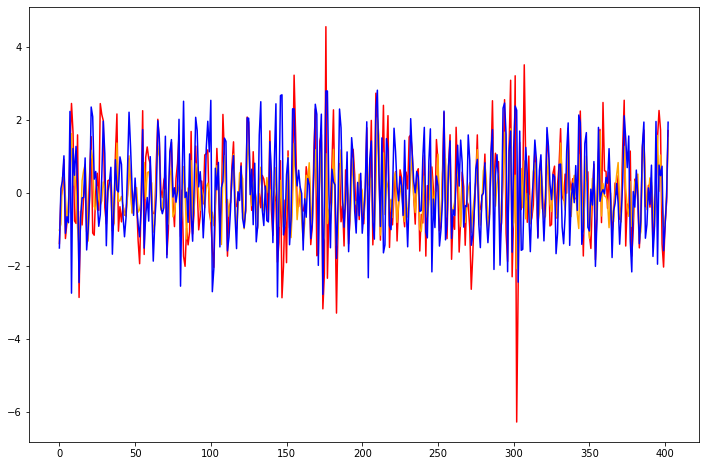

In [210]:
# print(np.dot(Ytest - predictionsGMap,Ytest - predictionsGMap))
# print(np.dot(Ytest - predictionsSMap,Ytest - predictionsSMap))

MSEG = np.dot(Ytest.flatten() - predictionsGMapSD,Ytest.flatten() - predictionsGMapSD)
MSES = np.dot(Ytest.flatten() - predictionsSMap,Ytest.flatten() - predictionsSMap)

print("GMap MSE ",MSEG)
print("SMap MSE ",MSES)
print("Improvement ", MSES / MSEG)

figGMap, axGMap = plt.subplots(1, figsize = (12,8))
axGMap.plot(predictionsGMapSD, c="red")
axGMap.plot(predictionsSMap, c="orange")
axGMap.plot(Ytest, c="blue")
plt.show()